Train/Val/Test split

LSTM Autoencoder

Randomized sentetik anomaly injection

Sliding windows

Reconstruction error hesaplama

Pointwise error atama

Thresholding + ROC/F1/AP skorları

Görselleştirme

In [170]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
import matplotlib.pyplot as plt

In [152]:

# ------------------ 0️⃣ Device ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [172]:
# ------------------ 1️⃣ Load Data ------------------
train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
val_df   = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
test_df = pd.read_csv("../data/processed/etth1_test.csv")

In [174]:
# ------------------ 2️⃣ Normalize ------------------
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df["OT"].values.reshape(-1, 1)).flatten()
print(f"Train series length: {len(train_scaled)}")
val_scaled   = scaler.transform(val_df["OT"].values.reshape(-1, 1)).flatten()

test_scaled = scaler.transform(test_df["OT"].values.reshape(-1, 1)).flatten()
print(f"Test series length: {len(test_scaled)}")


Train series length: 13936
Test series length: 1742


In [175]:

# ------------------ 3️⃣ Sliding window ------------------
def create_windows(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data) - window_size + 1)])


window_size = 96
train_windows = create_windows(train_scaled, window_size)
val_windows   = create_windows(val_scaled, window_size)
test_windows  = create_windows(test_scaled, window_size)

train_tensor = torch.tensor(train_windows, dtype=torch.float32).unsqueeze(-1)
val_tensor   = torch.tensor(val_windows, dtype=torch.float32).unsqueeze(-1)
test_tensor  = torch.tensor(test_windows, dtype=torch.float32).unsqueeze(-1)

batch_size = 64
train_loader_ae = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=batch_size, shuffle=True)
val_loader_ae   = DataLoader(TensorDataset(val_tensor, val_tensor), batch_size=batch_size, shuffle=False)
test_loader_ae  = DataLoader(TensorDataset(test_tensor, test_tensor), batch_size=batch_size, shuffle=False)


In [176]:
# ------------------ 4️⃣ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.enc_fc  = nn.Linear(hidden_dim, latent_dim)
        self.dec_fc  = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.output  = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        last_h = h_n[-1]
        latent = self.enc_fc(last_h)
        T = x.size(1)
        dec_input = self.dec_fc(latent).unsqueeze(1).repeat(1, T, 1)
        dec_input = self.layernorm(dec_input)
        dec_input = self.dropout(dec_input)
        dec_out, _ = self.decoder(dec_input)
        out = self.output(dec_out)
        return out

input_dim  = 1
hidden_dim = 64
latent_dim = 16
num_layers = 2

model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = nn.MSELoss()
# loss_fn= nn.SmoothL1Loss(beta=0.5) # make the loss more anomaly-sensitive(to boost recall)

In [177]:
# ------------------ 5️⃣ Training Loop ------------------
num_epochs = 100
patience   = 12
best_val   = np.inf
pat_cnt    = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, _ in train_loader_ae:
        xb = xb.to(device)
        noisy = xb + 0.02 * torch.randn_like(xb).to(device)
        optimizer.zero_grad()
        out = model(noisy)
        loss = loss_fn(out, xb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader_ae.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, _ in val_loader_ae:
            xb = xb.to(device)
            out = model(xb)
            val_loss += loss_fn(out, xb).item() * xb.size(0)
    val_loss /= len(val_loader_ae.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.6f} - Val: {val_loss:.6f}")

    if val_loss < best_val:
        best_val = val_loss
        pat_cnt = 0
        best_state = model.state_dict()
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_state)


Epoch 1/100 - Train: 0.246939 - Val: 0.077639
Epoch 2/100 - Train: 0.103076 - Val: 0.060932
Epoch 3/100 - Train: 0.089552 - Val: 0.056225
Epoch 4/100 - Train: 0.089532 - Val: 0.052915
Epoch 5/100 - Train: 0.086794 - Val: 0.055220
Epoch 6/100 - Train: 0.086462 - Val: 0.051684
Epoch 7/100 - Train: 0.084888 - Val: 0.052828
Epoch 8/100 - Train: 0.084256 - Val: 0.062410
Epoch 9/100 - Train: 0.082215 - Val: 0.051196
Epoch 10/100 - Train: 0.081687 - Val: 0.051450
Epoch 11/100 - Train: 0.083116 - Val: 0.050865
Epoch 12/100 - Train: 0.081228 - Val: 0.051151
Epoch 13/100 - Train: 0.082082 - Val: 0.051659
Epoch 14/100 - Train: 0.080747 - Val: 0.051339
Epoch 15/100 - Train: 0.081432 - Val: 0.076087
Epoch 16/100 - Train: 0.087040 - Val: 0.050858
Epoch 17/100 - Train: 0.080616 - Val: 0.050883
Epoch 18/100 - Train: 0.081385 - Val: 0.054302
Epoch 19/100 - Train: 0.080474 - Val: 0.051398
Epoch 20/100 - Train: 0.081494 - Val: 0.051753
Epoch 21/100 - Train: 0.073397 - Val: 0.035616
Epoch 22/100 - Train: 

<All keys matched successfully>

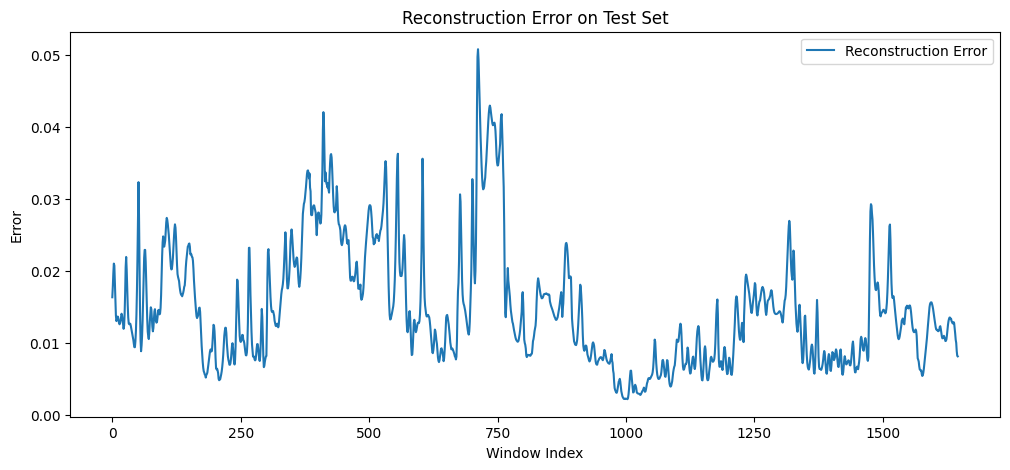

In [178]:
# evalueate on test set
model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader_ae:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        all_preds.append(preds)

all_preds = np.concatenate(all_preds, axis=0).squeeze(-1)
test_windows_np = test_windows

# Reconstruction error per window (MSE)
reconstruction_errors = np.mean((all_preds - test_windows_np) ** 2, axis=1)

plt.figure(figsize=(12, 5))
plt.plot(reconstruction_errors, label="Reconstruction Error")
plt.title("Reconstruction Error on Test Set")
plt.xlabel("Window Index")
plt.ylabel("Error")
plt.legend()
plt.show()

Test series length: 13936
Test series with anomalies length: 13936


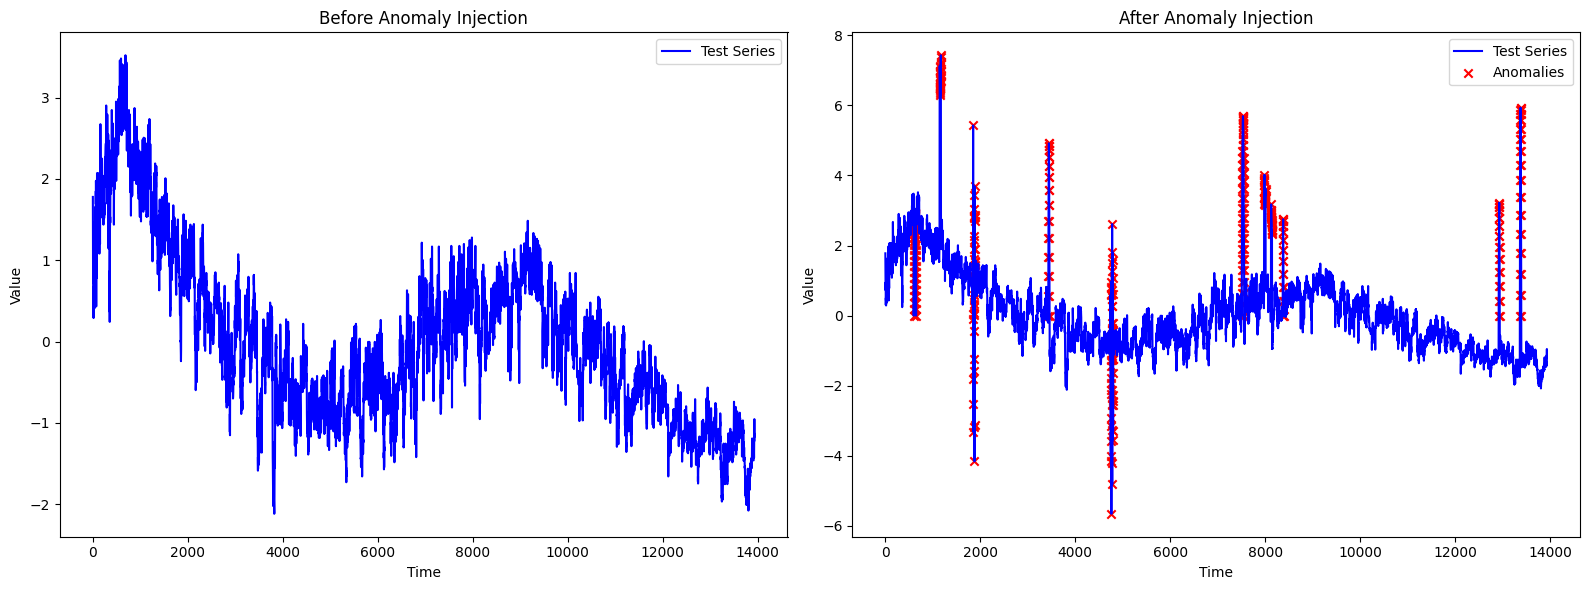

In [158]:
# # ------------------ 6️⃣ Random Synthetic Anomalies ------------------
# def generate_synthetic_anomalies(series, num_anomalies=10, window_lengths=(10,50), amplitude_range=(2.0,6.0)):
#     series = series.copy()
#     labels = np.zeros_like(series)
#     N = len(series)
#     rng = np.random.default_rng()
#     for _ in range(num_anomalies):
#         anomaly_type = rng.choice(['point', 'level_shift', 'noise_burst', 'collective'])
#         start_idx = rng.integers(0, N-1)
#         # if anomaly_type == 'point':
#         #     amp = rng.uniform(*amplitude_range)
#         #     series[start_idx] += amp
#         #     labels[start_idx] = 1
#         if anomaly_type == 'level_shift':
#             length = rng.integers(*window_lengths)
#             end = min(start_idx+length, N)
#             offset = rng.uniform(*amplitude_range)
#             series[start_idx:end] += offset
#             labels[start_idx:end] = 1
#         elif anomaly_type == 'noise_burst':
#             length = rng.integers(*window_lengths)
#             end = min(start_idx+length, N)
#             series[start_idx:end] += rng.normal(0, np.std(series)*2, end-start_idx)
#             labels[start_idx:end] = 1
#         elif anomaly_type == 'collective':
#             length = rng.integers(*window_lengths)
#             end = min(start_idx+length, N)
#             pattern = np.sin(np.linspace(0, np.pi, end-start_idx)) * rng.uniform(*amplitude_range)
#             series[start_idx:end] = pattern
#             labels[start_idx:end] = 1
#     return series, labels

# # Base test series (train_scaled üzerinden örnek)
# test_series = train_scaled.copy()
# test_series_original = test_series.copy()

# #print test set size before and after anomaly injection

# print(f"Test series length: {len(test_series)}")




# test_series, anomaly_labels = generate_synthetic_anomalies(test_series,
#                                                            num_anomalies=12,
#                                                            window_lengths=(20,60),
#                                                            amplitude_range=(2.0,6.0))

# print(f"Test series with anomalies length: {len(test_series)}")


# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # Plot before anomaly injection
# axes[0].plot(test_series_original, label='Test Series', color='blue')
# axes[0].set_title('Before Anomaly Injection')
# axes[0].set_xlabel('Time')
# axes[0].set_ylabel('Value')
# axes[0].legend()

# # Plot after anomaly injection
# axes[1].plot(test_series, label='Test Series', color='blue')
# axes[1].scatter(
#     np.where(anomaly_labels == 1)[0],
#     test_series[anomaly_labels == 1],
#     color='red',
#     label='Anomalies',
#     marker='x'
# )
# axes[1].set_title('After Anomaly Injection')
# axes[1].set_xlabel('Time')
# axes[1].set_ylabel('Value')
# axes[1].legend()

# plt.tight_layout()
# plt.show()


In [159]:
# ------------------ 7️⃣ Test loader ------------------
test_scaled = scaler.transform(test_series.reshape(-1,1)).flatten()
test_windows = create_windows(test_scaled, window_size)
test_tensor = torch.tensor(test_windows, dtype=torch.float32).unsqueeze(-1)
test_loader_ae = DataLoader(TensorDataset(test_tensor, test_tensor), batch_size=64, shuffle=False)
test_labels = np.array([1 if np.any(anomaly_labels[i:i+window_size]) else 0 for i in range(len(test_windows))])


In [160]:
# ------------------ 8️⃣ Reconstruction & Error ------------------
model.eval()
recons = []
with torch.no_grad():
    for xb, _ in test_loader_ae:
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        recons.append(out)
recons = np.vstack(recons).squeeze(-1)

window_mse = np.mean((recons - test_windows)**2, axis=1)

N = len(test_series)
pointwise_err = np.zeros(N)
counts = np.zeros(N)
half = window_size//2
for i, w_err in enumerate(window_mse):
    center_idx = i + half
    if center_idx < N:
        pointwise_err[center_idx] += w_err
        counts[center_idx] += 1
nonzero = counts>0
pointwise_err[nonzero] /= counts[nonzero]

valid_err = pointwise_err[half:]
valid_labels = anomaly_labels[half:]

Best threshold: 202.886537 with F1-score: 0.3766
ROC AUC: 0.9193
Precision: 0.5156, Recall: 0.2967, F1: 0.3766, AP: 0.2819


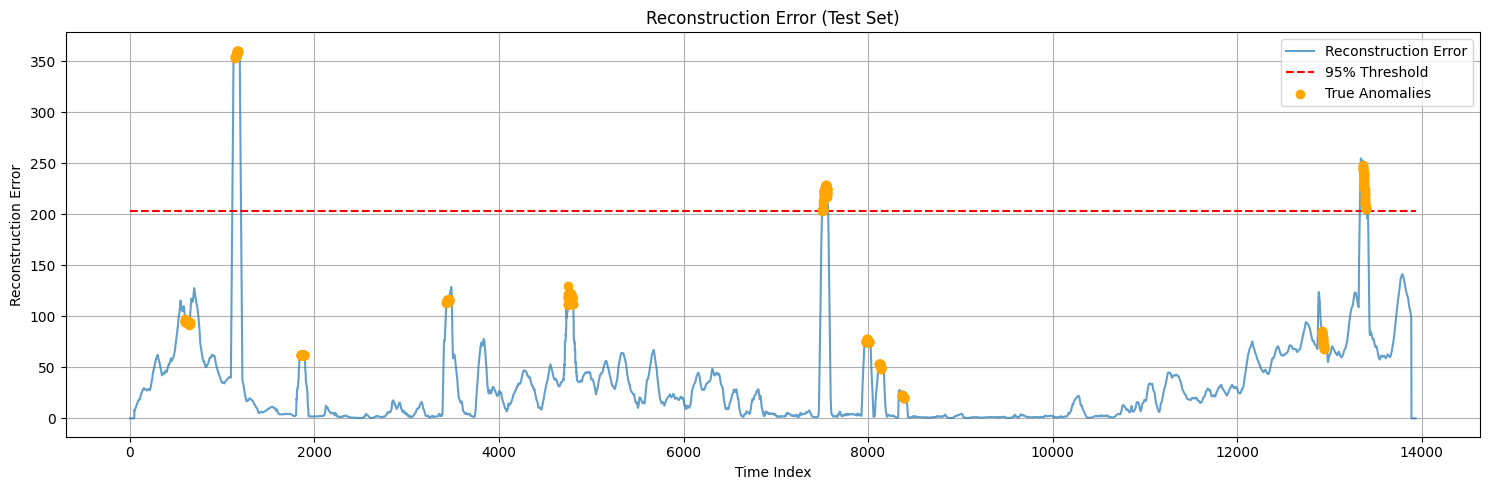

In [161]:
# ------------------ 9️⃣ Threshold Optimization & Metrics ------------------

# --- Threshold Optimization ---
# Try thresholds between 0 and max error
thresholds = np.linspace(valid_err.min(), valid_err.max(), 200)
f1_scores = []

for thr in thresholds:
    preds = (valid_err >= thr).astype(int)
    f1 = f1_score(valid_labels, preds)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.6f} with F1-score: {best_f1:.4f}")

preds = (valid_err >= best_threshold).astype(int)

roc_auc = roc_auc_score(valid_labels, valid_err)
precision = precision_score(valid_labels, preds)
recall    = recall_score(valid_labels, preds)
f1        = f1_score(valid_labels, preds)
ap_score  = average_precision_score(valid_labels, valid_err)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AP: {ap_score:.4f}")

# ------------------ 🔟 Plot ------------------
plt.figure(figsize=(15,5))
plt.plot(pointwise_err, label='Reconstruction Error', alpha=0.7)
plt.hlines(best_threshold, 0, len(pointwise_err), colors='r', linestyles='dashed', label='95% Threshold')
plt.scatter(np.where(anomaly_labels==1), pointwise_err[anomaly_labels==1], color='orange', label='True Anomalies', zorder=5)
plt.title('Reconstruction Error (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Confusion Matrix as string:
[[13388   109]
 [  275   116]]


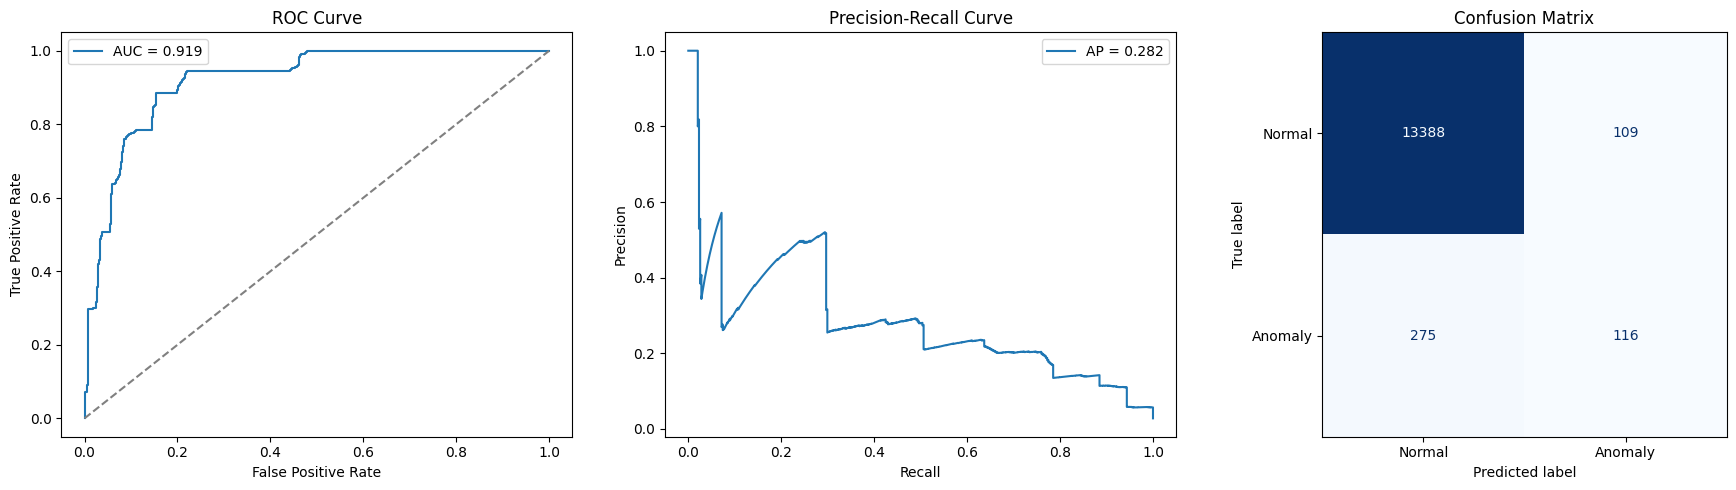

In [162]:
# --------- Plot ROC, Precision-Recall Curves and Confusion Matrix  ---------

from sklearn.metrics import roc_curve, precision_recall_curve,confusion_matrix, ConfusionMatrixDisplay

# Plot ROC and PR curves
fpr, tpr, _ = roc_curve(valid_labels, valid_err)
prec_curve, rec_curve, _ = precision_recall_curve(valid_labels, valid_err)

# Compute confusion matrix
cm = confusion_matrix(valid_labels, preds)

print("Confusion Matrix as string:")
print(str(cm))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])

plt.figure(figsize=(18, 5))

# ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 3, 2)
plt.plot(rec_curve, prec_curve, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# Confusion Matrix
plt.subplot(1,3,3)
disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [163]:
# print accuracy
accuracy = np.sum(preds == valid_labels) / len(valid_labels)
print(f"Accuracy: {accuracy:.4f}")

print(f"Predicted anomalies (TP+FP) = {np.sum(preds)}")
print(f"True anomalies = {np.sum(valid_labels)}")
print(f"Precision(actual anomalies percentage): {precision:.4f} (True anomalies / Predicted anomalies)")

print(f"Missed anomalies (FN): {np.sum((valid_labels == 1) & (preds == 0))}")
print(f"False alarms (FP): {np.sum((valid_labels == 0) & (preds == 1))}")


Accuracy: 0.9724
Predicted anomalies (TP+FP) = 225
True anomalies = 391.0
Precision(actual anomalies percentage): 0.5156 (True anomalies / Predicted anomalies)
Missed anomalies (FN): 275
False alarms (FP): 109


In [164]:
# Your model is good at identifying normal points (very few FPs, high TN rate).

# But it misses many anomalies (high FN count), meaning low recall.

# You are conservative in predicting anomalies — you catch fewer but with moderate precision.

# If the goal is to catch as many anomalies as possible, you might need to:

# Lower the threshold (to improve recall, but risk more false alarms).

# Use a more anomaly-sensitive loss function or model.

# Combine reconstruction error with other anomaly features.

In [165]:
# Quick roadmap (what I’d try first)
# Swap loss → SmoothL1Loss, retrain.

# Use combined score (MSE+MAE+MaxErr), re-run evaluation.

# Threshold via “max recall with precision ≥ X”; test X ∈ {0.4, 0.5, 0.6}.

# If false alarms still too high for desired recall, switch to FPR-capped thresholding and tune max_fpr.

In [166]:
# ---- A) Build richer anomaly score (window-level) ----
err_win = recons - test_windows                      # (num_windows, T)
window_mse    = np.mean(err_win**2, axis=1)
window_mae    = np.mean(np.abs(err_win), axis=1)
window_maxerr = np.max(np.abs(err_win), axis=1)

# Weighted combined score (tune weights for your data)
window_score = 0.4*window_mse + 0.4*window_mae + 0.2*window_maxerr

# ---- B) Map window score to pointwise score (center assignment) ----
N = len(test_series)
pointwise_score = np.zeros(N)
counts = np.zeros(N)
half = window_size // 2
for i, s in enumerate(window_score):
    j = i + half
    if j < N:
        pointwise_score[j] += s
        counts[j] += 1
mask = counts > 0
pointwise_score[mask] /= counts[mask]

valid_err = pointwise_score[half:]     # scores aligned to labels
valid_labels = anomaly_labels[half:]

In [167]:
# ---- C) Helper threshold selectors ----
def choose_threshold_max_recall_with_precision_floor(scores, y_true, min_precision=0.50):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    best_idx, best_rec, best_thr = None, -1.0, None
    # precision_recall_curve gives len(thr)+1 points; thresholds align to 1..end
    for i in range(1, len(prec)):
        if prec[i] >= min_precision and rec[i] > best_rec:
            best_rec = rec[i]
            best_idx = i
            best_thr = thr[i-1]
    if best_thr is not None:
        return float(best_thr), {"precision": float(prec[best_idx]), "recall": float(rec[best_idx]),
                                 "strategy": f"max recall with precision≥{min_precision}"}
    # fallback to max F1 if precision floor cannot be met
    grid = np.linspace(scores.min(), scores.max(), 200)
    f1s = [f1_score(y_true, (scores >= t).astype(int)) for t in grid]
    j = int(np.argmax(f1s))
    return float(grid[j]), {"precision": None, "recall": None, "strategy": "fallback: max F1"}


def choose_threshold_limit_fpr(scores, y_true, max_fpr=0.01):
    fpr, tpr, thr = roc_curve(y_true, scores)
    mask = fpr <= max_fpr
    if not np.any(mask):
        k = int(np.argmin(fpr))
        return float(thr[k]), {"strategy": f"min FPR fallback (target {max_fpr:.3f})", "fpr": float(fpr[k]), "tpr": float(tpr[k])}
    k = np.argmax(mask)  # largest index still within FPR limit
    return float(thr[k]), {"strategy": f"FPR≤{max_fpr:.3f}", "fpr": float(fpr[k]), "tpr": float(tpr[k])}

[Chosen threshold = 91.207718] Strategy: max recall with precision≥0.5
Precision=0.4979  Recall=0.2967  F1=0.3718  ROC-AUC=0.9244  AP=0.2949
Confusion Matrix:
 [[13380   117]
 [  275   116]]


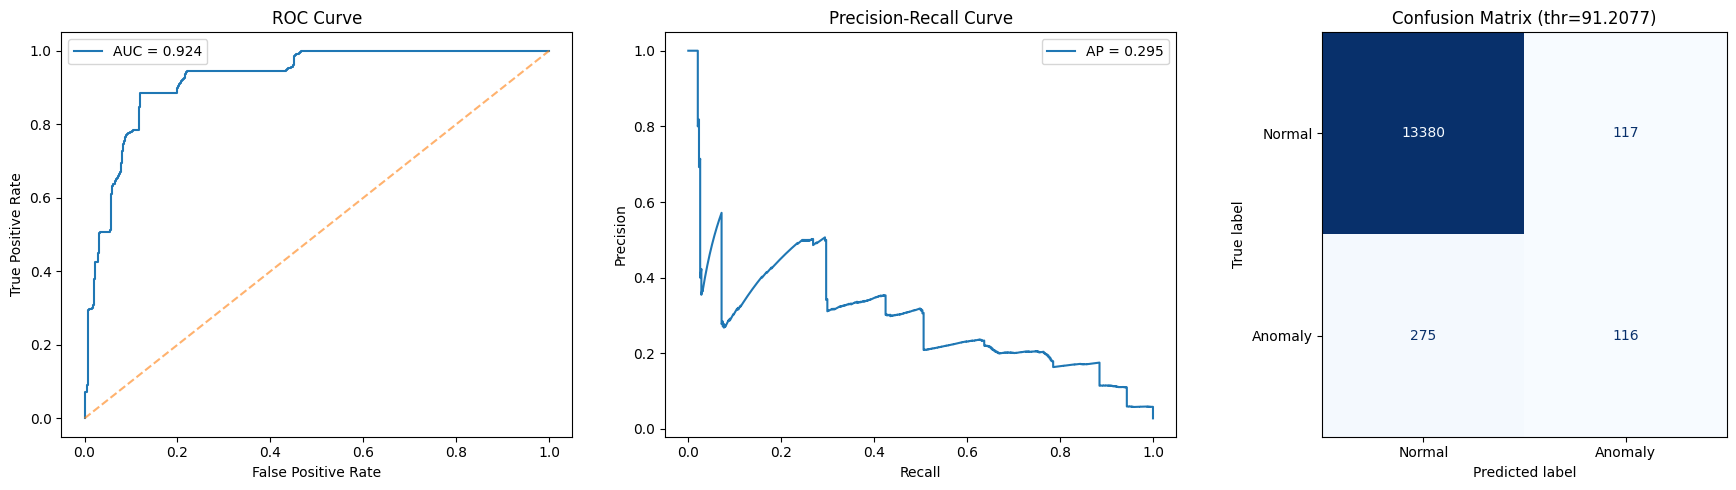

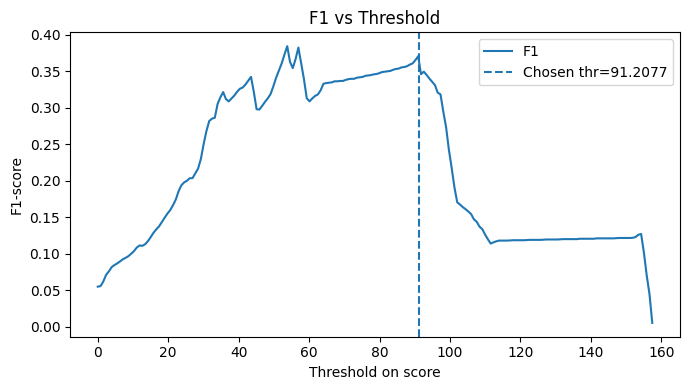

[Alt Threshold B = inf] Strategy: FPR≤0.010, Precision=0.0000 Recall=0.0000 F1=0.0000
CM:
[[13497     0]
 [  391     0]]


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [169]:
# ---- F) Plots: ROC, PR, Confusion Matrix, F1 vs Threshold ----
fpr, tpr, _ = roc_curve(valid_labels, valid_err)
prec_curve, rec_curve, thr_pr = precision_recall_curve(valid_labels, valid_err)

plt.figure(figsize=(18, 5))

# ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',alpha=0.6)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend()

# Precision-Recall
plt.subplot(1, 3, 2)
plt.plot(rec_curve, prec_curve, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend()

# Confusion Matrix
plt.subplot(1, 3, 3)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal","Anomaly"]).plot(
    ax=plt.gca(), cmap="Blues", colorbar=False
)
plt.title(f"Confusion Matrix (thr={chosen_thr:.4f})")
plt.tight_layout()
plt.show()

# F1 vs Threshold (to visualize trade-off)
thr_grid = np.linspace(valid_err.min(), valid_err.max(), 200)
f1_grid = [f1_score(valid_labels, (valid_err >= t).astype(int)) for t in thr_grid]
plt.figure(figsize=(7,4))
plt.plot(thr_grid, f1_grid, label="F1")
plt.axvline(chosen_thr, linestyle='--', label=f"Chosen thr={chosen_thr:.4f}")
plt.xlabel("Threshold on score"); plt.ylabel("F1-score")
plt.title("F1 vs Threshold"); plt.legend(); plt.tight_layout(); plt.show()

# (Optional) Show Option B threshold performance for comparison
y_pred_B = (valid_err >= thr_B).astype(int)
prec_B = precision_score(valid_labels, y_pred_B)
rec_B  = recall_score(valid_labels, y_pred_B)
f1_B   = f1_score(valid_labels, y_pred_B)
cm_B   = confusion_matrix(valid_labels, y_pred_B)
print(f"[Alt Threshold B = {thr_B:.6f}] Strategy: {info_B['strategy']}, "
      f"Precision={prec_B:.4f} Recall={rec_B:.4f} F1={f1_B:.4f}\nCM:\n{cm_B}")